# Probability Estimation and Ensembles

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Vector Graphics
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, brier_score_loss, mean_squared_error, r2_score, roc_auc_score, log_loss, accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor

In [2]:
import warnings
warnings.filterwarnings("ignore")

<div align="justify">

Another import class of methods is *ensemble learning*, such as [bagging](bagging) or [boosting](boosting), which are especially popular in machine learning due to their ability to improve accuracy of (point) predictions. 
Since such methods produce a (large) set of predictors $h_1, \ldots, h_M$ instead of a single hypothesis, it is tempting to produce probability estimates following basic frequentist principles. In the simplest case (of classification), each prediction $h_i(\vec{x})$ can be interpreted as a "vote" in favor of a class $y \in \mathcal{Y}$, and probabilities can be estimated by relative frequencies\,---\,needless to say, probabilities constructed in this way tend to be biased and are not necessarily well calibrated. Especially important in this field are tree-based methods such as [random forests](tf) ({cite:t}`brei_rf01,krup_pe14`).  

</div>

<div align="justify">

Obviously, while standard probability estimation is a viable approach to representing uncertainty in a prediction, 
there is no explicit distinction between different types of uncertainty. 
Methods falling into this category are mostly concerned with the aleatoric part of the overall uncertainty[^footNoteIdentifier].

</div>

<div align="justify">

[^footNoteIdentifier]: Yet, as will be seen later on, one way to go beyond mere aleatoric uncertainty is to combine the above methods, for example learning ensembles of probabilistic predictors (see [deep neural networks](../chapter-deep_neuralnetwork/dnn)). 

 </div>

<div align="justify">

The most popular ensembles use decision trees as the base learners and a wide variety of method have been explored in the literature on ensembles. Broadly, there are two classes of ensembles: randomization-based approaches, where the ensemble members can be trained in parallel without any interaction, 
and boosting-based approaches where the ensemble members are fit sequentially ({cite:t}`lakshminarayanan_simple_2017`). 

</div>

## Regression Uncertainty

<div align="justify">

Initially the ensemble model will be viewed as an approximation to Bayesian parameter estimation.
Let us first take a look at regressors for ensemble learning and uncertainty quantification. 
Below we first generate a synthetic dataset, 
then we apply bagging, boosting, and random forest regressors to see the performance. 

</div>

In [3]:
# X, y = make_classification(n_samples=1000, n_classes=2, n_features=20, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# clf = AdaBoostClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, y_train)

# y_prob = clf.predict_proba(X_test)

# y_test_bin = (y_test == 0).astype(int)
# y_prob_bin = y_prob[:, 0]

# fpr, tpr, _ = roc_curve(y_test_bin, y_prob_bin)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
# plt.plot([0, 1], [0, 1], lw=2, linestyle='--') # , color='black'
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc='lower right')
# plt.show()

(bagging)=
### Bagging

<div align="justify"> 

Bagging (Bootstrap Aggregating) involves training multiple models independently using different subsets of the training data, created by random sampling with replacement. 
Ensemble members are trained in parallel on different bootstrap samples of the original training set. If the base learner lacks intrinsic randomization (e.g., it can be trained efficiently by solving a convex optimization problem), bagging is a good mechanism for inducing diversity ({cite:t}`lakshminarayanan_simple_2017`). 
The predictions from all models are then averaged for regression.

</div>

In [4]:
np.random.seed(42)
X = np.linspace(0, 10, 1000).reshape(-1, 1)
y = (np.sin(X).ravel() + 0.5 * np.sin(3 * X).ravel() + np.random.normal(0, 0.5, X.shape[0]))

bagging = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=50, random_state=42)
bagging.fit(X, y)
y_bagging_pred = bagging.predict(X)
bagging_std = np.std([tree.predict(X) for tree in bagging.estimators_], axis=0)

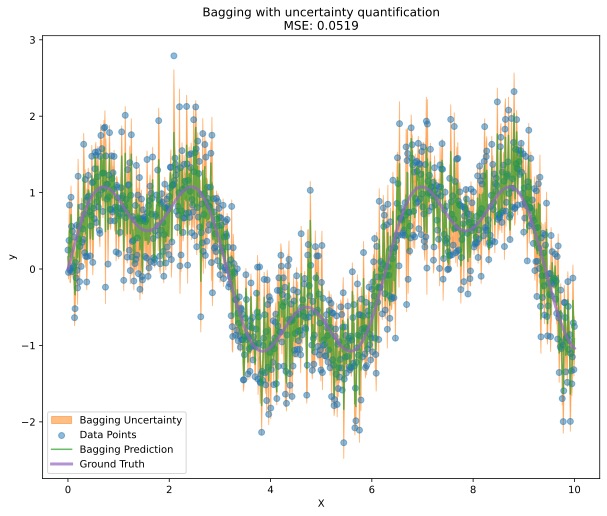

In [5]:
plt.figure(figsize=(10, 8))
plt.fill_between(X.ravel(), 
                 y_bagging_pred + bagging_std,
                 y_bagging_pred - bagging_std,
                 color='tab:orange', alpha=0.5, label='Bagging Uncertainty')
plt.scatter(X, y, marker='o', color='tab:blue', label='Data Points', alpha=0.5) # , cmap='viridis',  c=y, 
plt.plot(X, y_bagging_pred, color='tab:green', label='Bagging Prediction', linewidth=1.5, alpha=0.7)
plt.plot(X, np.sin(X) + 0.5 * np.sin(3 * X), color='tab:purple', label='Ground Truth', linewidth=3, alpha=0.7)

plt.xlabel('X')
plt.ylabel('y')
plt.title(f'Bagging with uncertainty quantification\nMSE: {mean_squared_error(y, y_bagging_pred):.4f}')
plt.legend(loc="lower left")
plt.show()

<div align="justify"> 

In the context of uncertainty quantification, bagging can provide an estimate of prediction uncertainty by analyzing the variance among the predictions from different models. Higher variance indicates greater uncertainty. 
Bagging shows pretty high uncertainty with large grey shaded area in this case. 

</div>

(boosting)=
### AdaBoost

<div align="justify"> 

Boosting can quantify uncertainty by examining the contribution of each model to the final prediction. If later models make significant corrections, it indicates higher uncertainty in the initial predictions. Here the models are trained sequentially, with each new model attempting to correct the errors made by the previous ones.
In boosting, each instance in the training data is assigned a weight.
Initially, all instances have equal weights. After each model is trained, the weights of mis-predicted instances are increased, so the next model focuses more on those difficult cases.

Boosting aims to reduce both bias and variance, but it primarily focuses on reducing bias by correcting errors iteratively.

</div>

In [6]:
boosting = AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=50, random_state=42)
boosting.fit(X, y)
y_boosting_pred = boosting.predict(X)

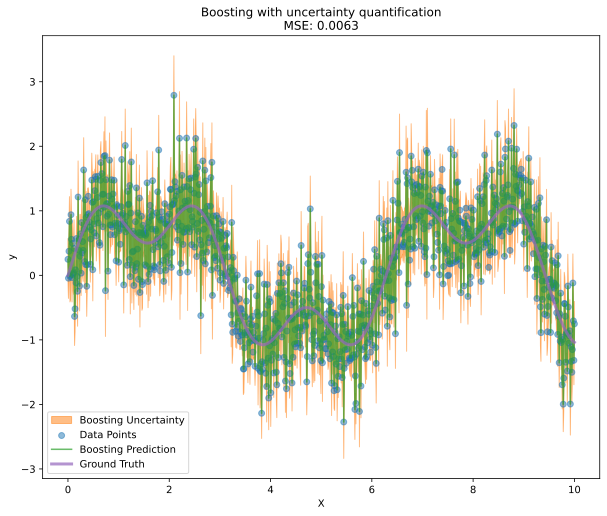

In [7]:
plt.figure(figsize=(10, 8))
plt.fill_between(X.ravel(), 
                 y_boosting_pred - np.std([tree.predict(X) for tree in boosting.estimators_], axis=0),
                 y_boosting_pred + np.std([tree.predict(X) for tree in boosting.estimators_], axis=0),
                 color='tab:orange', alpha=0.5, label='Boosting Uncertainty')
plt.scatter(X, y, marker='o', color='tab:blue', label='Data Points', alpha=0.5) # , cmap='viridis',  c=y, 
plt.plot(X, y_boosting_pred, color='tab:green', label='Boosting Prediction', linewidth=1.5, alpha=0.7)
plt.plot(X, np.sin(X) + 0.5 * np.sin(3 * X), color='tab:purple', label='Ground Truth', linewidth=3, alpha=0.7)

plt.xlabel('X')
plt.ylabel('y')
plt.title(f'Boosting with uncertainty quantification\nMSE: {mean_squared_error(y, y_boosting_pred):.4f}')
plt.legend(loc="lower left")
plt.show()

<div align="justify"> 

Boosting can assess uncertainty based on the corrections made by subsequent models. 
This visualization helps in understanding the confidence levels of the predictions made by boosting. 
That is, boosting are very confident with very low uncertainty about the predictions, as illustrated with lowest mean squared error. 

</div>

(rf)=
### Random Forest

<div align="justify"> 

Random forests create multiple decision trees during training by using different subsets of the data and a random subset of features for each tree. The final prediction is the average for regression tasks, leading to more stable and reliable predictions.
A random forest consists of multiple decision trees that are trained independently on different bootstrap samples of the data. This is the essence of the bagging approach. 

</div>

In [8]:
random_forest = RandomForestRegressor(n_estimators=50, random_state=42)
random_forest.fit(X, y)
y_rf_pred = random_forest.predict(X)

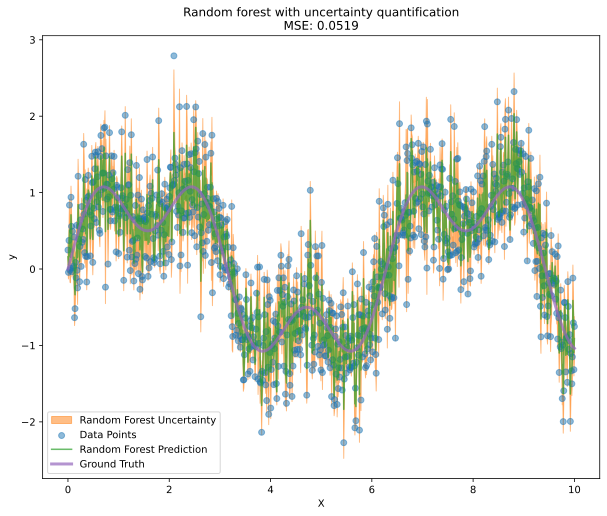

In [9]:
plt.figure(figsize=(10, 8))
plt.fill_between(X.ravel(), 
                 y_rf_pred - np.std([tree.predict(X) for tree in random_forest.estimators_], axis=0),
                 y_rf_pred + np.std([tree.predict(X) for tree in random_forest.estimators_], axis=0),
                 color='tab:orange', alpha=0.5, label='Random Forest Uncertainty')
plt.scatter(X, y, marker='o', color='tab:blue', label='Data Points', alpha=0.5) # , cmap='viridis',  c=y, 
plt.plot(X, y_rf_pred, color='tab:green', label='Random Forest Prediction', linewidth=1.5, alpha=0.7)
plt.plot(X, np.sin(X) + 0.5 * np.sin(3 * X), color='tab:purple', label='Ground Truth', linewidth=3, alpha=0.7)

plt.xlabel('X')
plt.ylabel('y')
plt.title(f'Random forest with uncertainty quantification\nMSE: {mean_squared_error(y, y_rf_pred):.4f}')
plt.legend(loc="lower left")
plt.show()

<div align="justify"> 


Random forests quantify uncertainty by analyzing the variance among the predictions from individual trees in the forest. 
Higher variance indicates greater uncertainty. 
Interestingly, the uncertainty measured by random forests and bagging is similar. 
One possible reason is that both bagging and random forests have mechanisms that inherently reduce uncertainty in predictions. 
Boosting algorithms, such as AdaBoost, sequentially train models where each model attempts to correct the errors of the previous one. 
This iterative correction process reduces the variance in predictions and leads to more confident predictions, hence narrower uncertainty regions. 
Random forests aggregate the predictions of many decision trees, each trained on a different random subset of the data. 
This averaging process reduces the overall variance and provides more stable and confident predictions, resulting in similar narrow uncertainty regions.

</div>

## Classification Uncertainty

<div align="justify"> 

Now let us discuss the classifiers for ensemble learning and uncertainty quantification as well. 
Similarly, 
we apply bagging, boosting, and random forest to see the performance in the classification report and confusion matrix. 

</div>

In [10]:
X, y = make_classification(n_samples=10000, n_classes=2, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

single_tree = DecisionTreeClassifier(random_state=42)
single_tree.fit(X_train, y_train)
y_single_tree_pred = single_tree.predict(X_test)

bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging.fit(X_train, y_train)
y_bagging_pred = bagging.predict(X_test)

boosting = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
boosting.fit(X_train, y_train)
y_boosting_pred = boosting.predict(X_test)

random_forest = RandomForestClassifier(n_estimators=50, random_state=42)
random_forest.fit(X_train, y_train)
y_rf_pred = random_forest.predict(X_test)

def calculate_classification_scores(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, output_dict=True)
    return accuracy, cm, cr

In [11]:
single_tree_accuracy, single_tree_cm, single_tree_report = calculate_classification_scores(y_test, y_single_tree_pred)
bagging_accuracy, bagging_cm, bagging_report = calculate_classification_scores(y_test, y_bagging_pred)
boosting_accuracy, boosting_cm, boosting_report = calculate_classification_scores(y_test, y_boosting_pred)
rf_accuracy, rf_cm, rf_report = calculate_classification_scores(y_test, y_rf_pred)

df_single_tree = pd.DataFrame(single_tree_report).transpose()
df_bagging = pd.DataFrame(bagging_report).transpose()
df_boosting = pd.DataFrame(boosting_report).transpose()
df_rf = pd.DataFrame(rf_report).transpose()

df_single_tree['Method'] = 'SingleTree'
df_bagging['Method'] = 'Bagging'
df_boosting['Method'] = 'Boosting'
df_rf['Method'] = 'RandomForest'

df_combined = pd.concat([df_single_tree,df_bagging, df_boosting, df_rf], axis=0)
cols = ['Method'] + [col for col in df_combined.columns if col != 'Method']
df_combined = df_combined[cols]
df_combined

,Method,precision,recall,f1-score,support
0,SingleTree,0.893910,0.904573,0.899209,1006.000
1,SingleTree,0.902240,0.891348,0.896761,994.000
accuracy,SingleTree,0.898000,0.898000,0.898000,0.898
macro avg,SingleTree,0.898075,0.897960,0.897985,2000.000
weighted avg,SingleTree,0.898050,0.898000,0.897993,2000.000
0,Bagging,0.954357,0.914513,0.934010,1006.000
1,Bagging,0.916988,0.955734,0.935961,994.000
accuracy,Bagging,0.935000,0.935000,0.935000,0.935
macro avg,Bagging,0.935673,0.935124,0.934985,2000.000
weighted avg,Bagging,0.935785,0.935000,0.934980,2000.000


<div align="justify">

We observe that the bagging approach performs very well in terms of the accuracy and F1 score, 
suggesting that bagging might be more robust in terms of handling variance in the data due to its ensemble nature. 
Note that we use a single tree as the estimator here.
Boosting rarely improves model performance, 
which might have caused it to overfit slightly, given that its accuracy is a bit lower. 
Random forest can effectively handle class imbalance by averaging multiple decision trees with the highest accuracy, which reduces variance and helps in capturing the diversity of the data by showing a higher precision for Class 1 and a higher recall for Class 0. 

Now let us have a look at the predicted probabilities and the variability in predictions from different methods with ensemble to gauge the aleatoric uncertainty. 

</div>

In [12]:
y_single_tree_prob = single_tree.predict_proba(X_test)
single_tree_uncertainty = np.std(y_single_tree_prob, axis=1)

y_bagging_prob = np.array([tree.predict_proba(X_test) for tree in bagging.estimators_])
bagging_uncertainty = np.std(y_bagging_prob, axis=0).mean(axis=1)

y_boosting_prob = np.array([estimator.predict_proba(X_test) for estimator in boosting.estimators_])
boosting_uncertainty = np.std(y_boosting_prob, axis=0).mean(axis=1)

y_rf_prob = np.array([tree.predict_proba(X_test) for tree in random_forest.estimators_])
rf_uncertainty = np.std(y_rf_prob, axis=0).mean(axis=1)

Text(627.9949494949494, 0.5, 'Actual')

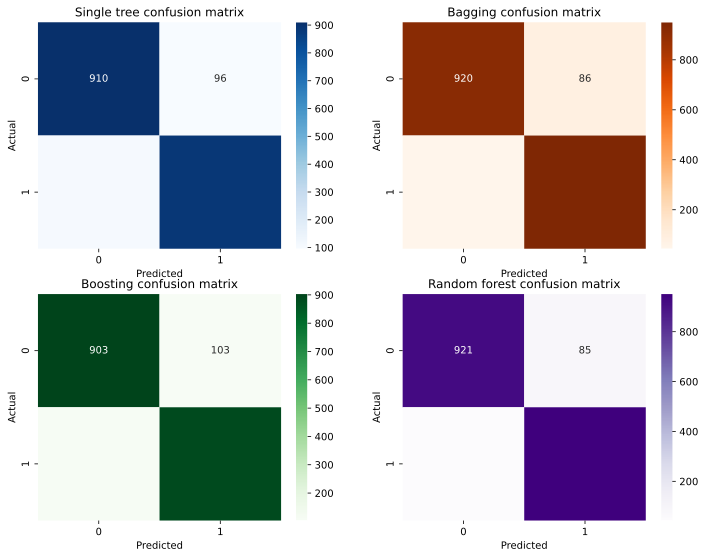

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))

sns.heatmap(single_tree_cm, annot=True, fmt='d', cmap='Blues', ax=axs[0, 0])
axs[0, 0].set_title('Single tree confusion matrix')
axs[0, 0].set_xlabel('Predicted')
axs[0, 0].set_ylabel('Actual')

sns.heatmap(bagging_cm, annot=True, fmt='d', cmap='Oranges', ax=axs[0, 1])
axs[0, 1].set_title('Bagging confusion matrix')
axs[0, 1].set_xlabel('Predicted')
axs[0, 1].set_ylabel('Actual')

sns.heatmap(boosting_cm, annot=True, fmt='d', cmap='Greens', ax=axs[1, 0])
axs[1, 0].set_title('Boosting confusion matrix')
axs[1, 0].set_xlabel('Predicted')
axs[1, 0].set_ylabel('Actual')

sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Purples', ax=axs[1, 1])
axs[1, 1].set_title('Random forest confusion matrix')
axs[1, 1].set_xlabel('Predicted')
axs[1, 1].set_ylabel('Actual')

<div align="justify">

Overall, ensemble methods (Bagging and Random Forest) outperform the single tree and boosting methods in this context, providing better classification performance with fewer errors. 
- *Bagging*: We can see the variation in predicted probabilities from different trees in the ensemble.
- *Boosting*: We can infer the uncertainty from the changes in predictions across the boosting rounds. 
- *Random forests*: We can analyze the variability in predicted probabilities from different trees in the forest like bagging method. 


</div>

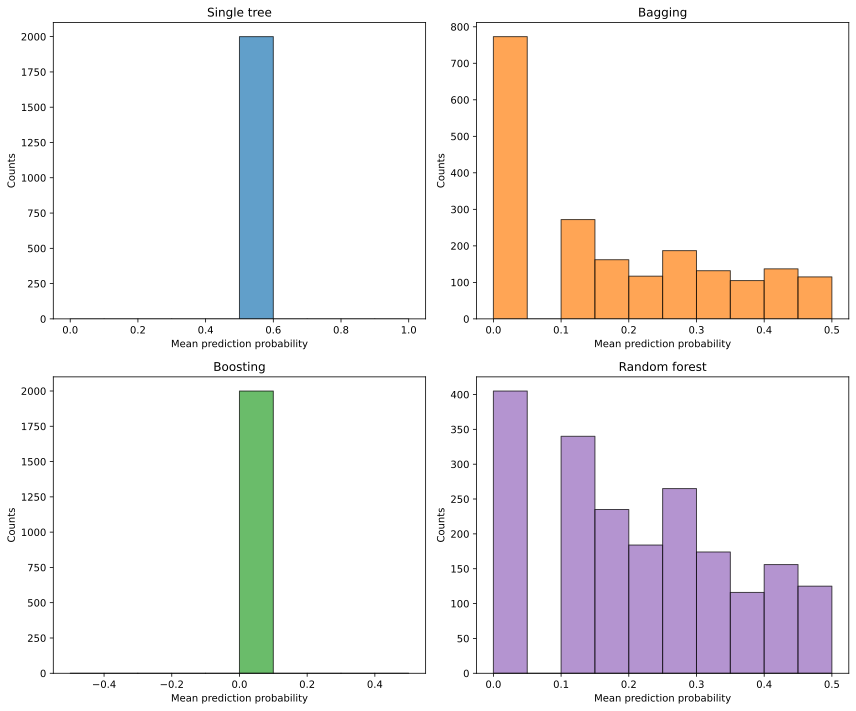

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].hist(single_tree_uncertainty, bins=10, edgecolor='k', color='tab:blue', alpha=0.7)
axs[0, 0].set_title('Single tree')
axs[0, 0].set_xlabel('Mean prediction probability')
axs[0, 0].set_ylabel('Counts')

axs[0, 1].hist(bagging_uncertainty, bins=10, edgecolor='k', color='tab:orange', alpha=0.7)
axs[0, 1].set_title('Bagging')
axs[0, 1].set_xlabel('Mean prediction probability')
axs[0, 1].set_ylabel('Counts')

axs[1, 0].hist(boosting_uncertainty, bins=10, edgecolor='k', color='tab:green', alpha=0.7)
axs[1, 0].set_title('Boosting')
axs[1, 0].set_xlabel('Mean prediction probability')
axs[1, 0].set_ylabel('Counts')

axs[1, 1].hist(rf_uncertainty, bins=10, edgecolor='k', color='tab:purple', alpha=0.7)
axs[1, 1].set_title('Random forest')
axs[1, 1].set_xlabel('Mean prediction probability')
axs[1, 1].set_ylabel('Counts')

plt.tight_layout()
plt.show()

<div align="justify"> 

As shown in the above figures, 
bagging classifier is fairly accurate, with a slight tendency to misclassify some instances. 
The Boosting classifier shows a similar performance to bagging but with a slight increase in misclassifications. 
The Random Forest classifier appears to perform marginally better than both bagging and Boosting in terms of fewer misclassifications. 

- *Single Tree*: The prediction probabilities are concentrated around 0.5, indicating that the single tree model is not confident in its predictions and often predicts probabilities near the decision threshold. 
- *Bagging uncertainty*: The histogram shows a distribution of uncertainty values, 
with a significant number of predictions having low uncertainty (around 0.0), indicating good overall performance with a balanced approach to uncertainty, 
even though some predictions have moderate uncertainty, 
reflecting variability in the data. 
- *Boosting uncertainty*: The histogram is highly skewed, showing almost all predictions with near-zero uncertainty. 
Boosting classifier is very confident in its predictions, with almost all uncertainty values near zero. 
While this indicates strong performance on training data, it might suggest overfitting, leading to potential issues in generalization.
- *Random forest uncertainty*: The histogram shows a more spread out distribution of uncertainty values compared to bagging. 
Random forest classifier acknowledges the complexity of the data with a more spread out uncertainty distribution. 
This balance might help in better generalization on unseen data. 

Again, Bagging and Random Forest show superior performance due to their ability to balance prediction confidence, reducing both false positives and false negatives, while Single Tree and Boosting exhibit higher error rates, potentially due to overconfidence in specific predictions, as indicated by their concentrated prediction probabilities.

Generally speaking, ensemble methods, particularly Random Forest, provide more robust and reliable predictions, as evidenced by both the confusion matrices and the distribution of prediction probabilities. 

</div>